In [13]:
import os
import sys
import warnings
from functools import partial, reduce
import pandas as pd
from sklearn.exceptions import DataConversionWarning
import numpy as np

PROJECT_PATH = os.path.join(os.getcwd(), '../')

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
    
from server.ml_models.match_model import MatchModelData
from server.ml_models.all_model import AllModelData
from server.ml_models import EnsembleModel
from server.data_processors import OppoFeatureBuilder

from src.model.metrics import yearly_performance_scores
from src.model.charts import graph_yearly_model_performance

SEED = 42

np.random.seed(SEED)
warnings.simplefilter("ignore", DataConversionWarning)

In [2]:
data = AllModelData(train_years=(None, 2016))
X_train, y_train = data.train_data()
X_train

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


team         oppo_team round_type  \
Adelaide         1991 1.0           Adelaide          Hawthorn    Regular   
                      2.0           Adelaide           Carlton    Regular   
                      3.0           Adelaide            Sydney    Regular   
                      4.0           Adelaide          Essendon    Regular   
                      5.0           Adelaide        West Coast    Regular   
                      6.0           Adelaide  Western Bulldogs    Regular   
                      7.0           Adelaide          St Kilda    Regular   
                      9.0           Adelaide   North Melbourne    Regular   
                      10.0          Adelaide         Melbourne    Regular   
                      11.0          Adelaide           Geelong    Regular   
                      12.0          Adelaide           Fitzroy    Regular   
                      13.0          Adelaide          Richmond    Regular   
                      14.0          Adelaide          Brisbane    Regular   
                      15.0          Adelaide       Collingwood    Regular   
                      16.0          Adelaide          Hawthorn    Regular   
                      17.0          Adelaide           Carlton    Regular   
                      18.0          Adelaide            Sydney    Regular   
                      19.0          Adelaide          Essendon    Regular   
                      20.0          Adelaide        West Coast    Regular   
                      21.0          Adelaide  Western Bulldogs    Regular   
                      22.0          Adelaide          St Kilda    Regular   
                      24.0          Adelaide   North Melbourne    Regular   
                 1992 1.0           Adelaide  Western Bulldogs    Regular   
                      3.0           Adelaide         Melbourne    Regular   
                      4.0           Adelaide           Fitzroy    Regular   
                      5.0           Adelaide          Richmond    Regular   
                      6.0           Adelaide          Brisbane    Regular   
                      7.0           Adelaide          St Kilda    Regular   
                      8.0           Adelaide           Geelong    Regular   
                      9.0           Adelaide       Collingwood    Regular   
...                                      ...               ...        ...   
Western Bulldogs 2015 21.0  Western Bulldogs        West Coast    Regular   
                      22.0  Western Bulldogs   North Melbourne    Regular   
                      23.0  Western Bulldogs          Brisbane    Regular   
                      24.0  Western Bulldogs          Adelaide     Finals   
                 2016 1.0   Western Bulldogs         Fremantle    Regular   
                      2.0   Western Bulldogs          St Kilda    Regular   
                      3.0   Western Bulldogs          Hawthorn    Regular   
                      4.0   Western Bulldogs           Carlton    Regular   
                      5.0   Western Bulldogs          Brisbane    Regular   
                      6.0   Western Bulldogs   North Melbourne    Regular   
                      7.0   Western Bulldogs          Adelaide    Regular   
                      8.0   Western Bulldogs         Melbourne    Regular   
                      9.0   Western Bulldogs               GWS    Regular   
                      10.0  Western Bulldogs       Collingwood    Regular   
                      11.0  Western Bulldogs        West Coast    Regular   
                      12.0  Western Bulldogs     Port Adelaide    Regular   
                      13.0  Western Bulldogs           Geelong    Regular   
                      15.0  Western Bulldogs            Sydney    Regular   
                      16.0  Western Bulldogs          Richmond    Regular   
                      17.0  Western Bulldogs        Gold Coast    Regular   
                      18.0  Western 

In [3]:
model = EnsembleModel()
scores = yearly_performance_scores([('ensemble', model, {})], X_train, y_train, data_frame=True)

scores

,accuracy,error,model,year
0,0.732143,30.196331,ensemble,2011
1,0.785024,27.781721,ensemble,2012
2,0.731884,26.966139,ensemble,2013
3,0.736715,29.035418,ensemble,2014
4,0.703883,30.424724,ensemble,2015
5,0.724638,28.038143,ensemble,2016


In [21]:
# Basing ELO calculations on:
# http://www.matterofstats.com/mafl-stats-journal/2013/10/13/building-your-own-team-rating-system.html

BASE_RATING = 1000
K = 35.6
X = 0.49
M = 130
# Home Ground Advantage
HGA = 9
S = 250
CARRYOVER = 0.575

def expected_outcome(prev_elo_score, prev_oppo_elo_score, at_home):
    hga = HGA if at_home else HGA * -1
    return 1 / (1 + 10**((prev_oppo_elo_score - prev_elo_score - hga) / S))

def actual_outcome(margin):
    return X + 0.5 - X**(1 + (margin / M))

def calculate_elo_score(prev_elo_score, prev_oppo_elo_score, margin, at_home):
    return (
        prev_elo_score + (K * (actual_outcome(margin) - expected_outcome(prev_elo_score, prev_oppo_elo_score, at_home)))
    )

# Assumes df sorted by year & round_number, with ascending=True
def calculate_match_elo_score(root_data_frame, cum_elo_scores, items):
    data_frame = root_data_frame.copy()
    index, row = items
    year, round_number, team = index

    if cum_elo_scores is None:
        elo_score = BASE_RATING
    else:
        prev_matches = data_frame.loc[
            (data_frame['team'] == team) &
            (data_frame['year'] == year) &
            (data_frame['round_number'] < round_number),
            :
        ]

        if not prev_matches.any().any():
            prev_matches = data_frame.loc[
                (data_frame['team'] == team) &
                (data_frame['year'] == year - 1),
                :
            ]

        if not prev_matches.any().any():
            elo_score = BASE_RATING
        else:
            prev_match = prev_matches.iloc[-1, :]
            prev_year, prev_round, _ = prev_match.name

            prev_elo_score = cum_elo_scores.loc[prev_match.name]
            prev_oppo_elo_score = cum_elo_scores.loc[prev_year, prev_round, prev_match['oppo_team']]
            prev_margin = prev_match['score'] - prev_match['oppo_score']
                
            elo_score = calculate_elo_score(prev_elo_score, prev_oppo_elo_score, prev_margin,
                                            prev_match['at_home'])

            if prev_match['year'] != year:
                elo_score = (elo_score * CARRYOVER) + (BASE_RATING * (1 - CARRYOVER))
    
    elo_data = [elo_score]
    elo_index = pd.MultiIndex.from_tuples([(year, round_number, team)])
    elo_scores = pd.Series(data=elo_data, index=elo_index)
    
    if cum_elo_scores is None:
        return elo_scores.copy()
        
    return cum_elo_scores.append(elo_scores)
    
def elo_column(data_frame):
    elo_data_frame = data_frame.reorder_levels([1, 2, 0]).sort_index(ascending=True)

    return (reduce(partial(calculate_match_elo_score, elo_data_frame), elo_data_frame.iterrows(), None)
            .reorder_levels([2, 0, 1])
            .sort_index())

In [22]:
ofb = OppoFeatureBuilder(oppo_feature_cols=['elo_rating'])

elo_data_frame = (
    data.data[data.data['year'] < 2017]
    .assign(elo_rating=elo_column,
           margin=lambda df: df['score'] - df['oppo_score'])
    .drop(['score', 'oppo_score'], axis=1)
)

elo_features = ofb.transform(elo_data_frame).drop('margin', axis=1)
elo_labels = elo_data_frame['margin']

elo_features

team         oppo_team round_type  \
Adelaide         1991 1           Adelaide          Hawthorn    Regular   
                      2           Adelaide           Carlton    Regular   
                      3           Adelaide            Sydney    Regular   
                      4           Adelaide          Essendon    Regular   
                      5           Adelaide        West Coast    Regular   
                      6           Adelaide  Western Bulldogs    Regular   
                      7           Adelaide          St Kilda    Regular   
                      9           Adelaide   North Melbourne    Regular   
                      10          Adelaide         Melbourne    Regular   
                      11          Adelaide           Geelong    Regular   
                      12          Adelaide           Fitzroy    Regular   
                      13          Adelaide          Richmond    Regular   
                      14          Adelaide          Brisbane    Regular   
                      15          Adelaide       Collingwood    Regular   
                      16          Adelaide          Hawthorn    Regular   
                      17          Adelaide           Carlton    Regular   
                      18          Adelaide            Sydney    Regular   
                      19          Adelaide          Essendon    Regular   
                      20          Adelaide        West Coast    Regular   
                      21          Adelaide  Western Bulldogs    Regular   
                      22          Adelaide          St Kilda    Regular   
                      24          Adelaide   North Melbourne    Regular   
                 1992 1           Adelaide  Western Bulldogs    Regular   
                      3           Adelaide         Melbourne    Regular   
                      4           Adelaide           Fitzroy    Regular   
                      5           Adelaide          Richmond    Regular   
                      6           Adelaide          Brisbane    Regular   
                      7           Adelaide          St Kilda    Regular   
                      8           Adelaide           Geelong    Regular   
                      9           Adelaide       Collingwood    Regular   
...                                    ...               ...        ...   
Western Bulldogs 2015 21  Western Bulldogs        West Coast    Regular   
                      22  Western Bulldogs   North Melbourne    Regular   
                      23  Western Bulldogs          Brisbane    Regular   
                      24  Western Bulldogs          Adelaide     Finals   
                 2016 1   Western Bulldogs         Fremantle    Regular   
                      2   Western Bulldogs          St Kilda    Regular   
                      3   Western Bulldogs          Hawthorn    Regular   
                      4   Western Bulldogs           Carlton    Regular   
                      5   Western Bulldogs          Brisbane    Regular   
                      6   Western Bulldogs   North Melbourne    Regular   
                      7   Western Bulldogs          Adelaide    Regular   
                      8   Western Bulldogs         Melbourne    Regular   
                      9   Western Bulldogs               GWS    Regular   
                      10  Western Bulldogs       Collingwood    Regular   
                      11  Western Bulldogs        West Coast    Regular   
                      12  Western Bulldogs     Port Adelaide    Regular   
                      13  Western Bulldogs           Geelong    Regular   
                      15  Western Bulldogs            Sydney    Regular   
                      16  Western Bulldogs          Richmond    Regular   
                      17  Western Bulldogs        Gold Coast    Regular   
                      18  Western Bulldogs          St Kilda    Regular   
                      19  Western Bulldogs           Geelong   

In [23]:
accuracy = ((elo_labels >= 0) & (elo_features['elo_rating'] > elo_features['oppo_elo_rating']) |
            (elo_labels <= 0) & (elo_features['elo_rating'] < elo_features['oppo_elo_rating'])).mean()

print('Accuracy of ELO rating model:', accuracy)

Accuracy of ELO rating model: 0.6914190317195326


In [24]:
elo_scores = yearly_performance_scores([('elo', model, {})], elo_features, elo_labels, data_frame=True)

elo_scores

,accuracy,error,model,year
0,0.778061,29.332329,elo,2011
1,0.780193,27.201808,elo,2012
2,0.741546,26.457962,elo,2013
3,0.736715,28.943990,elo,2014
4,0.711165,30.178136,elo,2015
5,0.734300,28.023385,elo,2016


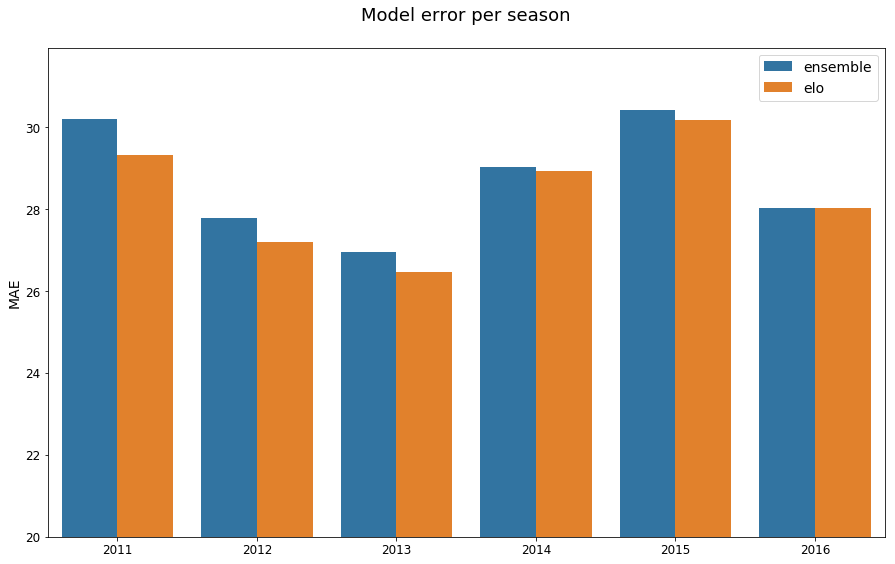

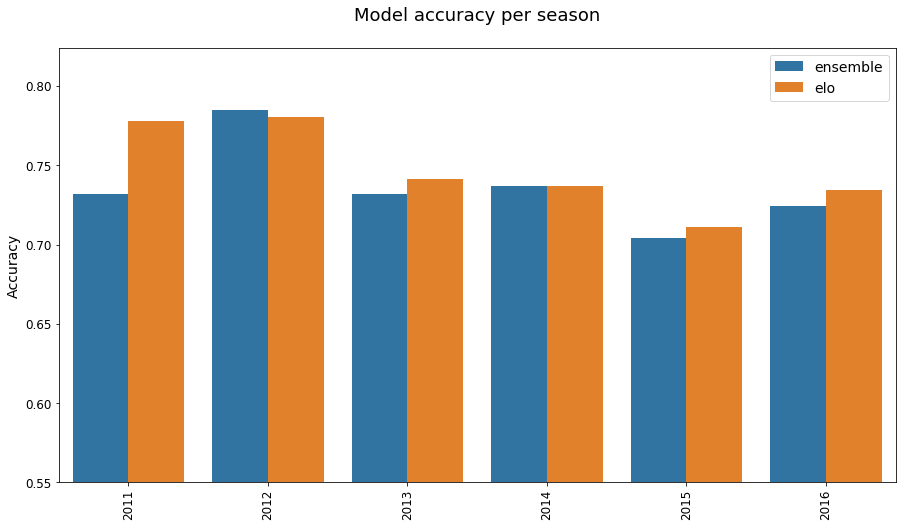

In [25]:
total_scores = pd.concat([scores, elo_scores])
graph_yearly_model_performance(total_scores)

In [26]:
total_scores.groupby('model').mean()[['error', 'accuracy']]

,error,accuracy
model,,
elo,28.356268,0.746997
ensemble,28.740413,0.735715
